In [1]:
# Import the necessary libraries
import sys
import numpy as np
import matplotlib.pyplot as plt
from src.utils import normalize, unnormalize
#%matplotlib inline
import torch
import copy
from torch import nn, optim
from torch.autograd import Variable
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import json
import itertools
import argparse
from argparse import RawTextHelpFormatter
import pandas as pd

In [2]:
def compute_metric(actual_y, pred_y, type):
    
    if type == 'mse':
        return mean_squared_error(actual_y, pred_y)
    elif type == 'mae':
        return mean_absolute_error(actual_y, pred_y)
    elif type == 'r2':
        return r2_score(actual_y, pred_y)

In [3]:
def compute_metrics_df(actual_y, pred_y_esn, pred_y_ar, pred_y_rnn, pred_y_lstm, pred_y_gru):
    
    pred_dicts = {
        "actual":actual_y,
        "esn":pred_y_esn,
        "linear_ar":pred_y_ar,
        "rnn":pred_y_rnn,
        "lstm":pred_y_lstm,
        "gru":pred_y_gru
    }
    
    df_metrics = []
    for model_name in ["esn", "linear_ar", "rnn", "lstm", "gru"]:
        df_metrics.append([model_name, 
                         compute_metric(pred_dicts["actual"], pred_dicts[model_name], type="mse"),
                         compute_metric(pred_dicts["actual"], pred_dicts[model_name], type="mae"),
                         compute_metric(pred_dicts["actual"], pred_dicts[model_name], type="r2"),
                          ])
    
    metrics_columns = ["Model_Name", "Test MSE", "Test MAE", "Test R2"]
    df_compare_metrics = pd.DataFrame(df_metrics, columns=metrics_columns)
    
    return df_compare_metrics

In [4]:
def compare_and_plot_preds(json_file, dataset=None, cycle_num=0, normalize_flag=False):
    
    with open(json_file) as f:
        comparison_results  = json.load(f)
    
    data = np.loadtxt(dataset)
    data[:, 1], Xmax, Xmin = normalize(X=data[:, 1], feature_space=(0, 1))
    
    if normalize_flag == False:
        
        ytest_0 = concat_data(comparison_results['original_test'], dim=0)
        ytest_1 = concat_data(comparison_results['original_test'], dim=1)
        pred_esn = np.array(comparison_results['pred_esn'])
        pred_ar = np.array(comparison_results['pred_ar'])
        pred_rnn = np.array(comparison_results['pred_rnn'])
        pred_lstm = np.array(comparison_results['pred_lstm'])
        pred_gru = np.array(comparison_results['pred_gru'])
        
        plot_all_preds(ytest_0=ytest_0,
               ytest_1=ytest_1,
              pred_esn=pred_esn,
              pred_ar=pred_ar,
              pred_rnn=pred_rnn,
              pred_lstm=pred_lstm,
              pred_gru=pred_gru,
              cycle_num=cycle_num)
        
        df_metrics = compute_metrics_df(actual_y=ytest_1,
                                       pred_y_esn=pred_esn,
                                       pred_y_ar=pred_ar,
                                       pred_y_rnn=pred_rnn,
                                       pred_y_lstm=pred_lstm,
                                       pred_y_gru=pred_gru
                                       )
        
    else:
        
        ytest_0 = concat_data(comparison_results['original_test'], dim=0)
        ytest_1_orig = unnormalize(concat_data(comparison_results['original_test'], dim=1), X_max=Xmax, X_min=Xmin)
        pred_esn_orig = unnormalize(np.array(comparison_results['pred_esn']), X_max=Xmax, X_min=Xmin)
        pred_ar_org = unnormalize(np.array(comparison_results['pred_ar']), X_max=Xmax, X_min=Xmin)
        pred_rnn_orig = unnormalize(np.array(comparison_results['pred_rnn']), X_max=Xmax, X_min=Xmin)
        pred_lstm_orig = unnormalize(np.array(comparison_results['pred_lstm']), X_max=Xmax, X_min=Xmin)
        pred_gru_orig = unnormalize(np.array(comparison_results['pred_gru']), X_max=Xmax, X_min=Xmin)
        
        plot_all_preds(ytest_0=ytest_0,
               ytest_1=ytest_1_orig,
              pred_esn=pred_esn_orig,
              pred_ar=pred_ar_org,
              pred_rnn=pred_rnn_orig,
              pred_lstm=pred_lstm_orig,
              pred_gru=pred_gru_orig,
              cycle_num=cycle_num)
        
        df_metrics = compute_metrics_df(actual_y=ytest_1_orig,
                                       pred_y_esn=pred_esn_orig,
                                       pred_y_ar=pred_ar_org,
                                       pred_y_rnn=pred_rnn_orig,
                                       pred_y_lstm=pred_lstm_orig,
                                       pred_y_gru=pred_gru_orig
                                       )
        
    return df_metrics


In [17]:
def compare_and_plot_future_preds(json_file, dataset=None, cycle_num=0, normalize_flag=False):
    
    with open(json_file) as f:
        comparison_results  = json.load(f)
    
    data = np.loadtxt(dataset)
    data[:, 1], Xmax, Xmin = normalize(X=data[:, 1], feature_space=(0, 1))
    
    if normalize_flag == False:
        
        pred_esn = np.array(comparison_results['pred_esn'])
        pred_ar = np.array(comparison_results['pred_ar'])
        pred_rnn = np.array(comparison_results['pred_rnn'])
        pred_lstm = np.array(comparison_results['pred_lstm'])
        pred_gru = np.array(comparison_results['pred_gru'])
        
        plot_all_future_preds(
              pred_esn=pred_esn,
              pred_ar=pred_ar,
              pred_rnn=pred_rnn,
              pred_lstm=pred_lstm,
              pred_gru=pred_gru,
              cycle_num=cycle_num)
        
    else:
        
        pred_esn_orig = unnormalize(np.array(comparison_results['pred_esn']), X_max=Xmax, X_min=Xmin)
        pred_ar_org = unnormalize(np.array(comparison_results['pred_ar']), X_max=Xmax, X_min=Xmin)
        pred_rnn_orig = unnormalize(np.array(comparison_results['pred_rnn']), X_max=Xmax, X_min=Xmin)
        pred_lstm_orig = unnormalize(np.array(comparison_results['pred_lstm']), X_max=Xmax, X_min=Xmin)
        pred_gru_orig = unnormalize(np.array(comparison_results['pred_gru']), X_max=Xmax, X_min=Xmin)
        
        plot_all_future_preds(
              pred_esn=pred_esn_orig,
              pred_ar=pred_ar_org,
              pred_rnn=pred_rnn_orig,
              pred_lstm=pred_lstm_orig,
              pred_gru=pred_gru_orig,
              cycle_num=cycle_num)
        
    return None

In [6]:
def plot_all_future_preds(pred_esn, pred_ar, pred_rnn, pred_lstm, pred_gru, cycle_num=None):
    # Plot the LSTM, GRU predictions
    plt.figure(figsize=(15,10))
    plt.rc('font', family='serif')
    plt.title("Compare predictions for given cycle {}".format(cycle_num), fontsize=20)
    plt.plot(pred_esn, '.-', label="ESN prediction", color="green")
    plt.plot(pred_ar, '.-', label="AR prediction", color="blue")
    plt.plot(pred_rnn, '.-', label="RNN prediction", color="black")
    plt.plot(pred_lstm, '.-', label="LSTM prediction", color="orange")
    plt.plot(pred_gru, '.-', label="GRU prediction", color="magenta")
    plt.legend(fontsize=16)
    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14, rotation=45)
    plt.grid(True)
    plt.show()

In [7]:
def plot_all_preds(ytest_0, ytest_1, pred_esn, pred_ar, pred_rnn, pred_lstm, pred_gru, cycle_num=None):
    # Plot the LSTM, GRU predictions
    plt.figure(figsize=(15,10))
    plt.rc('font', family='serif')
    plt.title("Compare predictions for given cycle {}".format(cycle_num), fontsize=20)
    plt.plot(ytest_0, ytest_1, '*-', label="actual test signal", color="red", linewidth=5)
    plt.plot(ytest_0, pred_esn, '.-', label="ESN prediction", color="green")
    plt.plot(ytest_0, pred_ar, '.-', label="AR prediction", color="blue")
    plt.plot(ytest_0, pred_rnn, '.-', label="RNN prediction", color="black")
    plt.plot(ytest_0, pred_lstm, '.-', label="LSTM prediction", color="orange")
    plt.plot(ytest_0, pred_gru, '.-', label="GRU prediction", color="magenta")
    plt.legend(fontsize=16)
    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14, rotation=45)
    plt.grid(True)
    plt.show()

In [8]:
def concat_data(X, dim=1):
    return np.vstack([x[dim] for x in X])

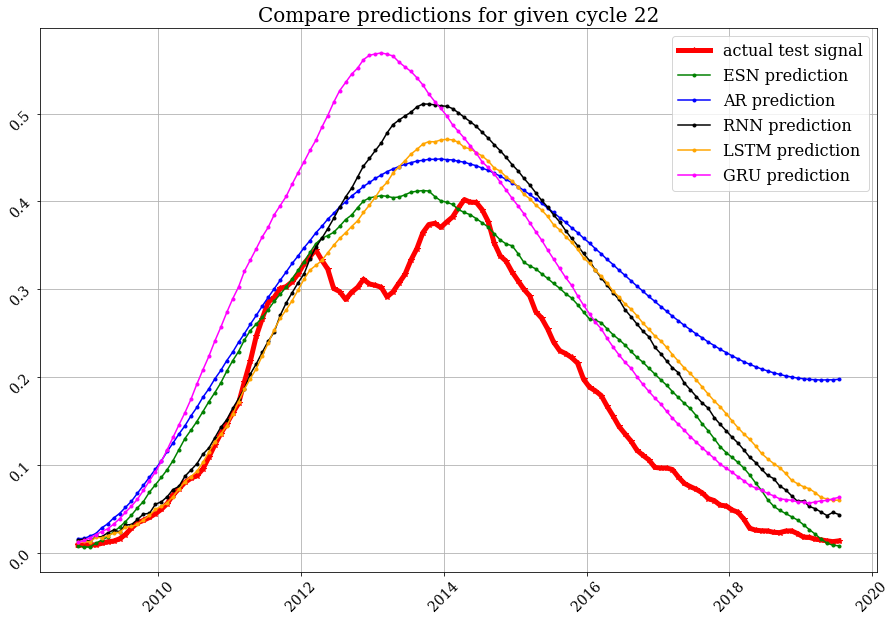

  Model_Name  Test MSE  Test MAE   Test R2
0        esn  0.003434  0.047571  0.801086
1  linear_ar  0.015352  0.107400  0.110696
2        rnn  0.009553  0.079214  0.446611
3       lstm  0.007910  0.072698  0.541786
4        gru  0.012985  0.093788  0.247803


In [10]:
df_metric_4000 = compare_and_plot_preds(json_file='./results/solar_cycle_22/compare_all_preds_solar_cycle22_osize5_eps4000.json',
                      dataset='./data/solar_data.txt',
                      cycle_num=22,
                      normalize_flag=False)

print(df_metric_4000)

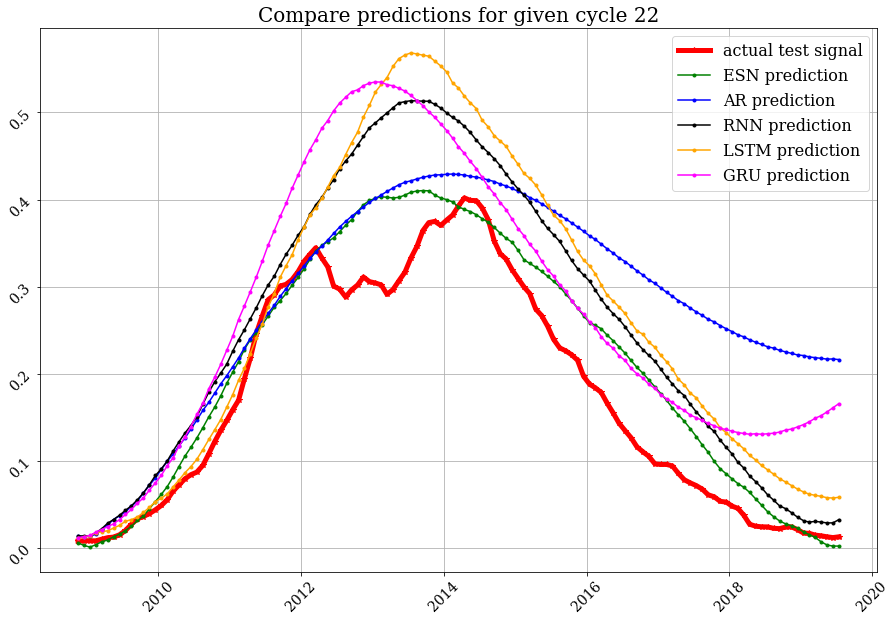

  Model_Name  Test MSE  Test MAE   Test R2
0        esn  0.002421  0.038145  0.859783
1  linear_ar  0.016682  0.104809  0.033642
2        rnn  0.008967  0.080012  0.480544
3       lstm  0.012713  0.089634  0.263574
4        gru  0.011719  0.092243  0.321171


In [11]:
df_metric_4000_latest = compare_and_plot_preds(json_file='./results/compare_all_preds_solar_cycle22_osize5_eps4000_tr3.json',
                      dataset='./data/solar_data.txt',
                      cycle_num=22,
                      normalize_flag=False)

print(df_metric_4000_latest)

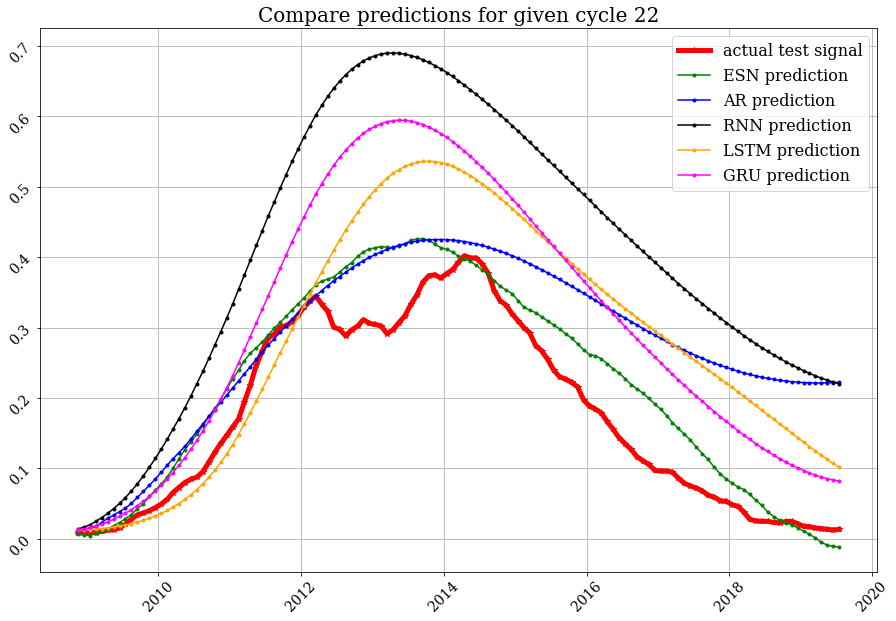

  Model_Name  Test MSE  Test MAE   Test R2
0        esn  0.003132  0.044979  0.818550
1  linear_ar  0.015399  0.101045  0.107946
2        rnn  0.062947  0.232065 -2.646358
3       lstm  0.018271  0.114584 -0.058401
4        gru  0.022064  0.128202 -0.278134


In [20]:
df_metric_4000_latest_osize1 =compare_and_plot_preds(json_file='./results/compare_all_preds_solar_cycle22_osize1_eps4000_tr3.json',
                      dataset='./data/solar_data.txt',
                      cycle_num=22,
                      normalize_flag=False)

print(df_metric_4000_latest_osize1)

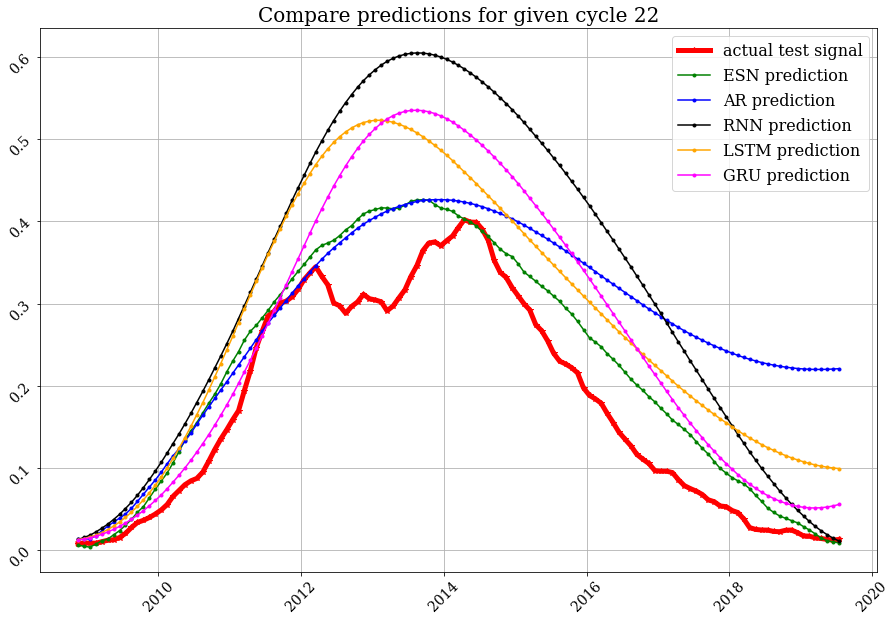

  Model_Name  Test MSE  Test MAE   Test R2
0        esn  0.003200  0.046656  0.814653
1  linear_ar  0.015381  0.101419  0.109045
2        rnn  0.028381  0.144939 -0.644029
3       lstm  0.012863  0.101480  0.254894
4        gru  0.011386  0.085390  0.340437


In [19]:
df_metric_4000_latest_osize1_2 =compare_and_plot_preds(json_file='./results/compare_all_preds_solar_cycle22_osize1_eps4000_tr4.json',
                      dataset='./data/solar_data.txt',
                      cycle_num=22,
                      normalize_flag=False)

print(df_metric_4000_latest_osize1_2)

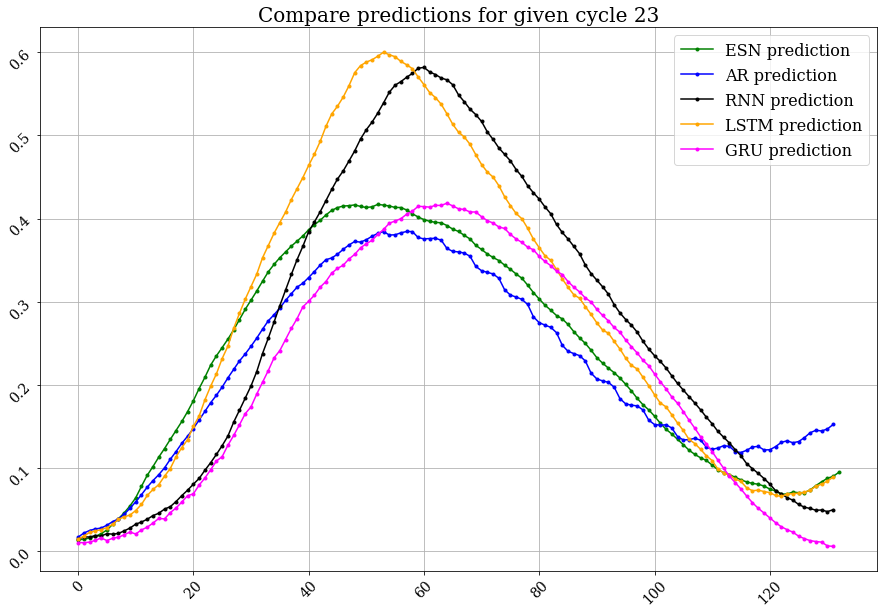

In [18]:
compare_and_plot_future_preds(json_file='./results/solar_cycle_23/compare_all_preds_solar_cycle23_osize5_eps4000_tr3.json',
                                                            dataset='./data/solar_data.txt',
                                                            cycle_num=23,
                                                            normalize_flag=False)
